# VegEdge


In [1]:
import os
import numpy as np
import pickle
import warnings
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import mpl_toolkits as mpl
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
import math
import geemap
import ee
import pprint
import geopandas as gpd
import matplotlib.cm as cm
import pyproj
import scipy
import csv
import math
from matplotlib import gridspec
from datetime import datetime, timezone, timedelta
from Elves import Download, Image_Processing, Shoreline, Toolbox, Transects, VegetationLine
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from matplotlib.ticker import MaxNLocator
from sklearn.datasets import load_diabetes
from shapely import geometry
from shapely.geometry import Point, LineString
from IPython.display import clear_output
from scipy import optimize
from pyproj import Proj

warnings.filterwarnings("ignore")
matplotlib.use('Qt5Agg')
plt.ion
ee.Initialize()

## Region of Interest Selection

Two options for image retrieval: 1st involes selecting region for the map generated below; 2nd involes inputting lat,lon coords manually.

**Option 1**

In [8]:
"""
Run this cell to generate a map. Use the polygon drawing tool on the left-hand side to 
draw out the region of coast you're interested in.
"""

Map = geemap.Map(center=[0,0],zoom=2)
Map.add_basemap('HYBRID')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Toggl…

In [ ]:
roi = Map.user_roi.geometries().getInfo()[0]['coordinates']
polygon = [[roi[0][0],roi[0][3],roi[0][1],roi[0][2]]]
point = ee.Geometry.Point(roi[0][0])

**Option 2**

In [2]:
##Below are example coordinates

##ST ANDREWS
lonmin, lonmax = -2.842023, -2.774955
latmin, latmax = 56.338343, 56.368490

##FELIXSTOWE
#lonmin, lonmax = 1.316128, 1.370888
#latmin, latmax = 51.930771, 51.965265

##BAY OF SKAILL
#lonmin, lonmax = -3.351555, -3.332693
#latmin, latmax = 59.048456, 59.057759

##SHINGLE STREET
#lonmin, lonmax = 1.446131, 1.460008
#latmin, latmax = 52.027039, 52.037448

##COVEHITHE
#

point = ee.Geometry.Point([lonmin, latmin]) 
polygon = [[[lonmin, latmin],[lonmax, latmin],[lonmin, latmax],[lonmax, latmax]]]

## Image Retrieval

In [3]:
# it's recommended to convert the polygon to the smallest rectangle (sides parallel to coordinate axes)       
polygon = Toolbox.smallest_rectangle(polygon)

# date range
dates = ['1940-05-01', '2021-12-02']
# satellite missions
# Input a list of containing any/all of 'L5', 'L8', 'S2'
sat_list = ['L5','L8','S2']

projection_epsg = 27700
image_epsg = 32630

# name of the site
sitename = 'ResearchData'
# directory where the data will be stored
filepath = os.path.join(os.getcwd(), 'Data')

# put all the inputs into a dictionnary
inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'sitename': sitename, 'filepath':filepath}

direc = os.path.join(filepath, sitename)

if os.path.isdir(direc) is False:
    os.mkdir(direc)

# before downloading the images, check how many images are available for your inputs
Download.check_images_available(inputs);

Images available between 1940-05-01 and 2021-12-02:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
  L5: 344 images
  L8: 289 images
  S2: 663 images
  Total: 1296 images
- In Landsat Tier 2:
  L5: 422 images
  L8: 110 images
  Total: 532 images


In [4]:
Sat = Toolbox.image_retrieval(point,dates, sat_list)
metadata = Toolbox.metadata_collection(sat_list, Sat, filepath, sitename)

Metadata already exists and was loaded


## Veg Line - Extraction

In [5]:
BasePath = 'Data/' + sitename + '/Veglines'

if os.path.isdir(BasePath) is False:
    os.mkdir(BasePath)

settings = {
    # general parameters:
    'cloud_thresh': 0.20,        # threshold on maximum cloud cover
    'output_epsg': image_epsg,     # epsg code of spatial reference system desired for the output   
    # quality control:
    'check_detection': False,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': False,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 50,     # minimum area (in metres^2) for an object to be labelled as a beach
    'buffer_size': 250,         # radius (in metres) for buffer around sandy pixels considered in the shoreline detection
    'min_length_sl': 100,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    'sand_color': 'bright',    # 'default', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    # add the inputs defined previously
    'inputs': inputs,
    'projection_epsg': projection_epsg,
    'hausdorff_threshold':350000000000000000000000000000000000000000000000000
}

Digitize a reference vegetation line

My nice new code

In [13]:
#Draw reference line onto the map then run the next cell

Map = geemap.Map(center=[0,0],zoom=2)
Map.add_basemap('HYBRID')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Toggl…

In [17]:
referenceLine = Map.user_roi.geometries().getInfo()[0]['coordinates']

for i in range(len(referenceLine)):
    #referenceLine[i][0], referenceLine[i][1] = referenceLine[i][1], referenceLine[i][0]
    referenceLine[i] = list(referenceLine[i])

referenceLine = Toolbox.convert_epsg(np.array(referenceLine),4326,32630)
settings['reference_shoreline'] = referenceLine
settings['max_dist_ref'] = 50

[[-2.833429, 56.353932], [-2.831883, 56.354265], [-2.830595, 56.35455], [-2.828964, 56.355073], [-2.827591, 56.355692], [-2.826904, 56.35669], [-2.82656, 56.357926], [-2.826217, 56.358735], [-2.825616, 56.360019], [-2.825015, 56.360874], [-2.824843, 56.362111], [-2.824156, 56.363109], [-2.823384, 56.364298], [-2.822611, 56.365106], [-2.821838, 56.366152], [-2.82098, 56.367055], [-2.819434, 56.367388], [-2.817803, 56.366294], [-2.816601, 56.365486], [-2.815399, 56.364773], [-2.814369, 56.363917], [-2.81351, 56.362966], [-2.812824, 56.362301], [-2.812051, 56.360827], [-2.811622, 56.359733], [-2.811278, 56.358735], [-2.810935, 56.357641], [-2.810677, 56.356975], [-2.810076, 56.355929], [-2.809733, 56.354693], [-2.809389, 56.353837], [-2.808874, 56.352791], [-2.808359, 56.351792], [-2.807844, 56.350603]]


The old code

In [6]:
%matplotlib qt
settings['reference_shoreline'] = Image_Processing.get_reference_sl(metadata, settings, polygon, dates)
settings['max_dist_ref'] = 150 # max distance (in meters) allowed from the reference shoreline

Reference shoreline already exists and was loaded


Extracts vegetation lines from all selected images. This'll take a while...

In [ ]:
%matplotlib qt
output, output_latlon, output_proj = VegetationLine.extract_veglines(metadata, settings, polygon, dates)

Mapping shorelines:
L5:   100%
L8:   100%
S2:   3%Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'QA60' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
S2:   11%Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'QA60' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
S2:   62%

In [42]:
#Alternatively, load the output file if previously processed
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output.pkl'), 'rb') as f:
    output = pickle.load(f)
with open(os.path.join(filepath, sitename + '_output_latlon.pkl'), 'rb') as f:
    output_latlon = pickle.load(f)
with open(os.path.join(filepath, sitename + '_output_proj.pkl'), 'rb') as f:
    output_proj = pickle.load(f)

In [43]:
output = Toolbox.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output_latlon = Toolbox.remove_duplicates(output_latlon)
output_proj = Toolbox.remove_duplicates(output_proj)

9 duplicates
9 duplicates
9 duplicates


Visual Display of Vegetation Lines. Will tank your PC if you've got lots of lines

In [20]:
#Creates map object centred at ROI + adds compiled satellite image as base-layer
#Map = geemap.Map(center=[polygon[0][0][1],polygon[0][0][0]],zoom=12)
#Map.add_basemap('HYBRID')

#Generates colours for lines to be drawn in. Check out https://seaborn.pydata.org/tutorial/color_palettes.html for colour options...
palette = sns.color_palette("bright", len(output['shorelines']))
palette = palette.as_hex()

#Choose 'points' or 'lines' for the layer geometry
geomtype = 'points'

for i in range(len(output['shorelines'])):
    shore = dict([])
    if len(output_latlon['shorelines'][i])==0:
        continue
    shore = {'dates':[output_latlon['dates'][i]], 'shorelines':[output_latlon['shorelines'][i]], 'filename':[output_latlon['filename'][i]], 'cloud_cover':[output_latlon['cloud_cover'][i]], 'idx':[output_latlon['idx'][i]], 'Otsu_threshold':[output_latlon['Otsu_threshold'][i]], 'satname':[output_latlon['satname'][i]]}
    gdf = Toolbox.output_to_gdf(shore, geomtype)
    Line = geemap.geopandas_to_ee(gdf, geodesic=True)
    Map.addLayer(Line,{'color': str(palette[i])},'coast'+str(i))

Map

TransportError: Unable to find the server at accounts.google.com

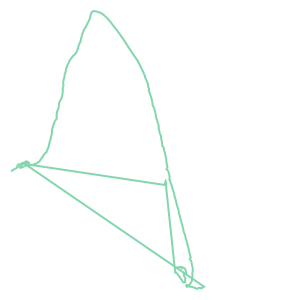

In [22]:
LineString(output['shorelines'][122])
#LineString(output['shorelines'][0])


In [23]:
#Saves the veglines as individual shape-files locally under /Veglines.
direc = os.path.join(filepath, '/Veglines')
geomtype = 'lines'
name_prefix = 'Data/' + sitename + '/Veglines'

if os.path.isdir(direc) is False:
    os.mkdir(direc)

Toolbox.save_shapefiles(output_latlon, geomtype, name_prefix, sitename)

ref_line = np.delete(settings['reference_shoreline'],2,1)
ref = {'dates':['3000-12-30'], 'shorelines':[ref_line], 'filename':[0], 'cloud_cover':[0], 'geoaccuracy':[0], 'idx':[0], 'Otsu_threshold':[0], 'satname':[0]}
    
Toolbox.save_shapefiles(ref, geomtype, name_prefix, sitename)

In [10]:
#Produces Transects and Coast shape-files for the reference line

SmoothingWindowSize = 21
NoSmooths = 100
TransectSpacing = 10
DistanceInland = 350
DistanceOffshore = 350
BasePath = 'Data/' + sitename + '/Veglines'

Transects.produce_transects(SmoothingWindowSize, NoSmooths, TransectSpacing, DistanceInland, DistanceOffshore, image_epsg, sitename, BasePath + '/' + sitename + '_referenceLine')

#(Optional) Produces transects for all produced lines
#Transects.produce_transects_all(SmoothingWindowSize, NoSmooths, TransectSpacing, DistanceInland, DistanceOffshore, projection_epsg, BasePath)

Coast: Initialising Coast object
Coast.ReadCoastShp: Read Coastline, no of coast segments is 1
	Coastline    1 /    1
Coast: Smoothing CoastLines
Coast.WriteCoastShp: Writing coast line to a shapefile
Coast.GenerateTransectNormals: Generating CoastLine transects perpendicular to the coast
Coast.WriteTransectsShp: Writing coastal transects and attributes to a shapefile


In [9]:
#Defines all transects in a library.

TransectSpec =  '/' + sitename + '_referenceLine/Transect.shp'
geo = gpd.read_file(BasePath+TransectSpec)

transect_latlon, transect_proj = Transects.stuffIntoLibrary(geo, image_epsg, projection_epsg, filepath, sitename)

Current Progress: 99.85 %


In [10]:
#Or just load them if already produced
with open(os.path.join(filepath, sitename + '_transect_proj' + '.pkl'), 'rb') as f:
    transect_proj = pickle.load(f)
with open(os.path.join(filepath, sitename + '_transect_latlon' + '.pkl'), 'rb') as f:
    transect_latlon = pickle.load(f)

In [11]:
settings['along_dist'] = 50
cross_distance = Transects.compute_intersection(output_proj, transect_proj, settings, 'vegetation_') 

Time-series of the shoreline change along the transects saved as:
C:\Users\luker\OneDrive - Durham University\Research_Work\CoastWatch\Data\ResearchData\vegetation_transect_time_series.csv


In [ ]:
#Or just load it if it already exists :)

cross_distance = dict([])

with open('Data/'+sitename+'/vegetation_transect_time_series.csv', newline='') as csvfile:
    spamreader = csv.DictReader(csvfile, delimiter=',', quotechar='|')
    for lines in spamreader:
        for i in range(len(lines)-2):
            cross_distance['Transect_'+str(i+1)] = []

with open('Data/'+sitename+'/vegetation_transect_time_series.csv', newline='') as csvfile:
    spamreader = csv.DictReader(csvfile, delimiter=',', quotechar='|')
    for lines in spamreader:
        for i in range(len(lines)-2):
            transect_name = 'Transect Transect_' + str(i+1)
            try:
                cross_distance['Transect_'+str(i+1)].append(float(lines[transect_name]))
            except:
                cross_distance['Transect_'+str(i+1)].append(np.nan)

## Analysis - Vegetation Edge

In [12]:
#Displays produced lines/transects

fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
#plt.xlim(509000,513000)
#plt.ylim(6244400,6247250)
plt.grid(linestyle=':', color='0.5')
for i in range(len(output_proj['shorelines'])):
    sl = output_proj['shorelines'][i]
    date = output_proj['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.')#, label=date.strptime('%d-%m-%Y'))
 
for i,key in enumerate(list(transect_proj.keys())):
    plt.plot(transect_proj[key][0,0],transect_proj[key][0,1], 'bo', ms=5)
    plt.plot(transect_proj[key][:,0],transect_proj[key][:,1],'k-',lw=1)
    #plt.text(transects_proj[key][0,0]-100, transects_proj[key][0,1]+100, key, va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))
plt.show()

In [ ]:
#Displays the transects

for i,key in enumerate(list(transect_proj.keys())):
    plt.plot(transect_proj[key][0,0],transect_proj[key][0,1], 'bo', ms=5)
    plt.plot(transect_proj[key][:,0],transect_proj[key][:,1],'k-',lw=1)
    #plt.text(transects_proj[key][0,0]-100, transects_proj[key][0,1]+100, key, va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))
plt.show()

In [ ]:
#Displays the lines

fig = plt.figure(figsize=[15,8])
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output_proj['shorelines'])):
    sl = output_proj['shorelines'][i]
    date = output_proj['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.')#, label=date.strftime('%d-%m-%Y'))
plt.legend()
plt.show()

In [ ]:
#Cross-distance plots for ALL transects (do not bother if you are considering a LOT of transects)

fig = plt.figure(figsize=[15,12], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),2, wspace=0.035, width_ratios=[3,1])
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.2)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.set_ylim([-100,110])
    ax.plot(output['dates'], cross_distance[key]- np.nanmedian(cross_distance[key]), '-o', ms=6, mfc='w')
    #ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',va='top', transform=ax.transAxes, fontsize=14)
    if i!= len(cross_distance.keys())-1:
        ax.set_xticklabels('')
    ax = fig.add_subplot(gs[i,1])
    #ax.set_xlim([-50,50])
    ax.set_xlim([0,0.015])
    sns.distplot(cross_distance[key]- np.nanmedian(cross_distance[key]), bins=10, color="b", ax=ax, vertical=True)
    ax.set_yticklabels('')
    if i!= len(cross_distance.keys())-1:
        ax.set_xticklabels('')
fig.text(0.01, 0.5, 'Cross-Shore Distance / m', va='center', rotation='vertical', fontsize=12)


In [ ]:
transect_range = [[0, 50],[51,110],[111,180],[181,240],[241,len(output['dates'])-1]]
#transect_colour = sns.color_palette("bright", len(transect_range))
colours = ['#ff0000','#0084ff','#ff00f7','#00fa0c', '#ffb300', '#00ffcc','#7b00ff']
transect_colour = colours

In [ ]:
#In this cell, you can iterate on transect range (we will use these ranges to analyse specific regions of the edge)

fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
#plt.xlim(509000,513000)
#plt.ylim(6244400,6247250)
plt.grid(linestyle=':', color='0.5')
for i in range(len(output_proj['shorelines'])):
    sl = output_proj['shorelines'][i]
    date = output_proj['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.')#, label=date.strptime('%d-%m-%Y'))

if transect_range == 'full':
    transect_range = [[0,len(transect_proj.keys())]]   

for i,key in enumerate(list(transect_proj.keys())):
    for j in range(len(transect_range)):
        if transect_range[j][0] <= i <= transect_range[j][1]:
            plt.plot(transect_proj[key][0,0],transect_proj[key][0,1], 'bo', ms=5,color=transect_colour[j])
            plt.plot(transect_proj[key][:,0],transect_proj[key][:,1],'k-',lw=1,color=transect_colour[j])
    #plt.text(transects_proj[key][0,0]-100, transects_proj[key][0,1]+100, key, va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))

plt.savefig('Data/' + sitename + '/jpg_files/transectsFull', bbox_inches='tight')
  
plt.show()

In [ ]:
#Year by Year

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

fig, axs = plt.subplots(len(transect_range),sharex=True,figsize=(10, 12))
fig.text(0.005, 0.5, "Average Yearly Vegetation Cross-Edge Distance / m", va='center', rotation='vertical', fontsize=12)

for i in range(len(transect_range)):
    axs[i].set_title("Transects:"+str(transect_range[i][0])+"-"+str(transect_range[i][1]),backgroundcolor=transect_colour[i],color='white')
    if i != len(transect_range)-1:
        axs[i].xaxis.set_visible(False)
    if i == len(transect_range)-1:
        axs[i].set_xlabel("Year", fontsize=12)
    for j in range(transect_range[i][0],transect_range[i][1]):
        KEY = 'Transect_'+str(j+1)
        try:
            a, b, c, d, e = Toolbox.Separate_TimeSeries_year(cross_distance, output_proj, KEY)
            NaN_mask = np.isfinite(e)
            axs[i].plot(np.array(d)[NaN_mask],np.array(e)[NaN_mask])
        except:
            continue
            
plt.savefig('Data/' + sitename + '/jpg_files/avgYearlyVegPosition', bbox_inches='tight')


In [ ]:
#Good at looking at seasonal patterns. Takes a while.

#plt.figure(figsize=[15,12])

months = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
Month_dict = {"Jan":[], "Feb":[], "Mar":[], "Apr":[], "May":[], "June":[], "July":[], "Aug":[], "Sept":[], "Oct":[], "Nov":[], "Dec":[]}

Total_Month_Arr = []
test1 = []
test2 = []

fig, axs = plt.subplots(len(transect_range),sharex=True,figsize=(10, 12))

for l in range(len(transect_range)):

    for i in range(transect_range[l][0],transect_range[l][1]):
        KEY = 'Transect_'+str(i+1)
        try:
            a, b, c, d, e = Toolbox.Separate_TimeSeries_month(cross_distance, output_proj,KEY)

            zipped_lists = zip(d,e)
            s = sorted(zipped_lists)
            tuples = zip(s)

            new_d = []
            new_e = []

            sortedList = [list(tuple) for tuple in  tuples]

            for v in range(len(sortedList)):
                new_d.append(sortedList[v][0][0])
                new_e.append(sortedList[v][0][1])

            month_arr = []
            for j in range(len(d)):
                a = datetime.strptime(str(new_d[j]),'%m')
                month_arr.append(a.strftime('%b'))

            axs[l].scatter(month_arr,new_e,label=KEY)
            test1.append(new_d)
            test2.append(new_e)
        except:
            continue

    avg = []
    st_err = []
    Total_organised = []
    temp = []

    for k in range(len(test2[0])):
        for h in range(len(test2)):
            temp.append(test2[h][k])
        Total_organised.append(temp)
        avg.append(np.nanmean(temp))
        st_err.append(np.nanstd(temp)/(len(temp)**0.5))
        temp = []
    
    Total_Month_Arr.append(Total_organised)
    
    #plt.errorbar(month_arr,avg, yerr=st_err, color='k')
    axs[l].scatter(month_arr,avg, color='k', s=50, marker='x')

    #plt.legend()
    axs[l].set_title("Transects:"+str(transect_range[l][0])+"-"+str(transect_range[l][1]),backgroundcolor=transect_colour[l],color='white')

fig.text(0.01,0.5,"Averaged Monthly Vegetation Cross-Edge Distance / m", va='center', rotation='vertical')
plt.xlabel("Month")

plt.savefig('Data/' + sitename + '/jpg_files/monthScatter', bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(len(transect_range),sharex=True,figsize=(10, 12))

for j in range(len(Total_Month_Arr)):
    
    axs[j].set_title("Transects:"+str(transect_range[j][0])+"-"+str(transect_range[j][1]),backgroundcolor=transect_colour[j],color='white')
    axs[j].boxplot(Total_Month_Arr[j],notch=True, flierprops = dict(marker='o', markersize=8, linestyle='none', markeredgecolor='r'))

fig.text(0.01,0.5,"Averaged Monthly Vegetation Cross-Edge Distance / m", va='center', rotation='vertical')
plt.xticks(new_d, month_arr)

plt.savefig('Data/' + sitename + '/jpg_files/monthBox', bbox_inches='tight')

plt.show()

In [ ]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    #ax.set_xlabel('Sample name')

fig, axs = plt.subplots(len(transect_range),sharex=True,figsize=(10, 12))

for j in range(len(Total_Month_Arr)):
    
    axs[j].set_title("Transects:"+str(transect_range[j][0])+"-"+str(transect_range[j][1]),backgroundcolor=transect_colour[j],color='white')
    parts = axs[j].violinplot(Total_Month_Arr[j], showmeans=False, showmedians=False, showextrema=False)

    for pc in parts['bodies']:
        pc.set_facecolor(transect_colour[j])
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

    quartile1, medians, quartile3 = np.percentile(Total_Month_Arr[j], [25, 50, 75], axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(Total_Month_Arr[j], quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

    inds = np.arange(1, len(medians) + 1)
    axs[j].scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    axs[j].vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    axs[j].vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
    
    if j == len(Total_Month_Arr):
        set_axis_style(axs[j], month_arr)

fig.text(0.005,0.5,"Averaged Monthly Vegetation Cross-Edge Distance / m", va='center', rotation='vertical')
plt.xticks(new_d, month_arr)

plt.savefig('Data/' + sitename + '/jpg_files/monthViolin', bbox_inches='tight')

plt.show()

In [ ]:
#array of colours for each of the averaged transect-analysis (add more if need be)
colours = ['#ff0000','#0084ff','#ff00f7','#00fa0c', '#ffb300', '#00ffcc','#7b00ff']

Rows = []

with open('Data/'+sitename+'/vegetation_transect_time_series.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        Rows.append(row[2:])

cross_distance_condensed, standard_err_condensed, transect_condensed, Dates = Transects.transect_compiler(Rows, transect_proj, 100, output)

In [ ]:
fig = plt.figure(figsize=[15,12], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance_condensed),2, wspace=0.035, width_ratios=[4,1])
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)

x = np.arange(datetime(1984,1,1), datetime(2022,1,1), timedelta(days=100)).astype(str)
y = [0]*139

for i,key in enumerate(cross_distance_condensed.keys()):
    
    if np.all(np.isnan(cross_distance_condensed[key])):
        continue
        
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.set_ylim([min(cross_distance_condensed[key]- np.nanmedian(cross_distance_condensed[key]))-5,max(cross_distance_condensed[key]- np.nanmedian(cross_distance_condensed[key]))+5])
    dates = matplotlib.dates.date2num(Dates[key])
    ax.errorbar(dates, cross_distance_condensed[key]- np.nanmedian(cross_distance_condensed[key]), yerr = standard_err_condensed[key],fmt='-o',ecolor= 'k', color= colours[i], ms=6, mfc='w')

    ax.fill_between(dates, 0, cross_distance_condensed[key]- np.nanmedian(cross_distance_condensed[key]),alpha=0.5,color=colours[i])
    ax.set_title("Transects:"+str(transect_range[i][0])+"-"+str(transect_range[i][1]),backgroundcolor=transect_colour[i],color='white')

    ax.set_xticklabels(['1982','1986','1992','1998','2004','2010','2016','2020','2014','2018','2022'])

    if i!= len(cross_distance_condensed.keys())-1:
        ax.set_xticklabels('')

    ax = fig.add_subplot(gs[i,1])
    ax.set_xlim([0,0.020])
    sns.distplot(cross_distance_condensed[key]- np.nanmedian(cross_distance_condensed[key]), bins=10, color=colours[i], ax=ax, vertical=True)
    ax.set_yticklabels('')
    
    if i!= len(cross_distance_condensed.keys())-1:
        ax.set_xticklabels('')
        ax.set_xlabel('')
        
fig.text(0.01, 0.5, 'Cross Vegetation-Edge Distance / m', va='center', rotation='vertical', fontsize=13.8)

plt.savefig('Data/' + sitename + '/jpg_files/crossEdgeDistances', bbox_inches='tight')

In [ ]:
ref_sl_conv = Toolbox.convert_epsg(settings['reference_shoreline'], 32630, 27700)[:,:-1]

vv = dict([])
vv['1'] = [ref_sl_conv]

#Displays produced lines/transects

fig = plt.figure()#figsize=[15,8], tight_layout=True)
plt.axis('equal')
#plt.xlabel('Eastings')
#plt.ylabel('Northings')
plt.xlim(min(vv['1'][0][:,0]),max(vv['1'][0][:,0]))
plt.xticks('')
plt.yticks('')
plt.ylim(min(vv['1'][0][:,1])-50,max(vv['1'][0][:,1])+50)
plt.grid(linestyle=':', color='0.5')
for i in range(len(vv['1'])):
    sl = vv['1'][i]
    date = vv['1'][i]
    plt.plot(sl[:,0], sl[:,1], '.', color='k')#, label=date.strptime('%d-%m-%Y'))
 
for i,key in enumerate(list(transect_condensed.keys())):
    plt.plot(transect_condensed[key][0,0],transect_condensed[key][0,1], 'bo', color= colours[i], ms=5)
    plt.plot(transect_condensed[key][:,0],transect_condensed[key][:,1],'k-', color= colours[i], lw=1)
    plt.text(transect_condensed[key][1][0],transect_condensed[key][1][1], key, va='bottom', ha='right', bbox=dict(boxstyle="round", ec='k',fc='w'), fontsize=10)

plt.savefig('Data/' + sitename + '/jpg_files/refEdge_Transects', bbox_inches='tight')
plt.show()

In [ ]:
Big_percent = []
for i,key in enumerate(cross_distance_condensed.keys()):
    cross = cross_distance_condensed[key]- np.nanmedian(cross_distance_condensed[key])
    percent_diff = []
    for j in range(len(cross)):
        percent_diff.append(100*(cross[j]-cross[0])/cross[0])
        
    Big_percent.append(percent_diff)

In [ ]:
Big_arr = []
Big_datearr = []

Year = [[]]*(2021-1984)

for i in range(len(transect_range)):
    percent_diff = []
    dist_arr = []
    date_arr = []
    for j in range(transect_range[i][0],transect_range[i][1]):
        KEY = 'Transect_'+str(j+1)
        try:
            a, b, c, d, e = Toolbox.Separate_TimeSeries_year(cross_distance, output_proj, KEY)
            NaN_mask = np.isfinite(e)
            dist_arr.append(list(np.array(e)[NaN_mask]))
            date_arr.append(list(np.array(d)[NaN_mask]))
            #percent_diff.append()
        except:
            continue
    Big_arr.append(dist_arr)
    Big_datearr.append(date_arr)

In [ ]:
Big_Percent = []

for j in range(len(Big_arr)):
    Medium_Percent_TransectRange = []
    Year = dict([])
    for i in range(len(Big_arr[j])):
        for k in range(len(Big_arr[j][i])):
            index = Big_datearr[j][i][k]-1984
            if Year.get(str(index)) == None:
                Year[str(index)] = []
            Year[str(index)].append(Big_arr[j][i][index-1])
            #print(len(Year[index-1]))
    List_year = []
    for v, key in enumerate(Year):
        List_year.append(np.mean(Year[key]))
    Big_Percent.append(List_year[1:])
    #print(List_year)

In [ ]:
Barz = []

for i in range(len(Big_Percent)):
    temp = []
    for j in range(len(Big_Percent[i])):
        temp.append(100*(Big_Percent[i][j]-Big_Percent[i][0])/Big_Percent[i][0])
    Barz.append(temp)

In [ ]:
fig, axs = plt.subplots(figsize=(10, 12))
for i in range(len(Barz)):
    axs.barh(np.arange(len(Barz[i]))+(i/5), Barz[i], align='center',height= 0.2,color=colours[i],label='Transects: '+str(transect_range[i][0])+"-"+str(transect_range[i][1]) )
axs.plot([0]*100,np.arange(0,37,0.37),'-.',color='k')
axs.set_xlabel("% Change Since 1984")
#axs.set_xlim(-500,500)
axs.set_yticks(np.arange(0,37,1))
axs.set_yticklabels(list(np.array(d)[NaN_mask]))
fig.text(0.25,0.85,"Accretion (Relative to 1984)")
fig.text(0.58,0.85,"Erosion (Relative to 1984)")
axs.legend(loc='lower right')
for i in range(37):
    axs.plot(np.arange(-500,500,10),[i-0.1]*100,'-.',color='k',alpha=0.7,linewidth=0.45)
fig.savefig(os.path.join('Data/' + sitename + '/jpg_files/barBreakdown.jpg'), dpi=150)
plt.show()

In [11]:
Sentinel2 = ee.ImageCollection("COPERNICUS/S2").filterBounds(point).filterDate(dates[0], dates[1]).filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 98.5))

0.030446

In [15]:
Sentinel2.getInfo().get('features')[4]['properties']['CLOUDY_PIXEL_PERCENTAGE']/100

0.684263